In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

C:\Users\computer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

#### Display the first 25 images from the training set and display the class name below each image. 

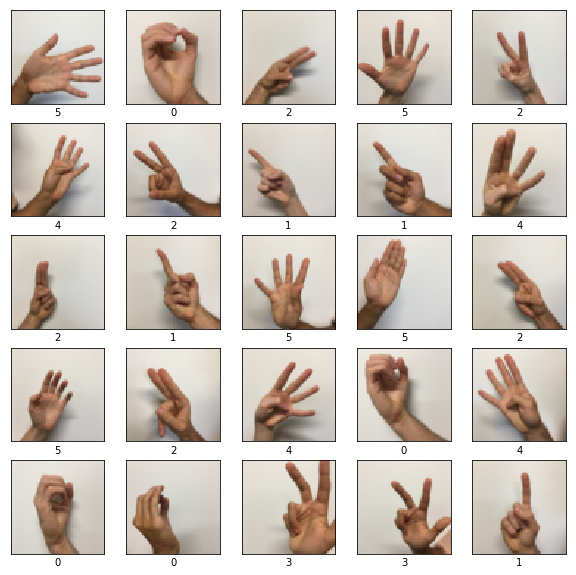

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_orig[i])
    plt.xlabel(np.squeeze(Y_train_orig[:, i]))

In [12]:
print ("number of training examples = " + str(X_train_orig.shape[1]))
print ("number of test examples = " + str(X_test_orig.shape[1]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

number of training examples = 64
number of test examples = 64
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


### Preprocess the data

In [11]:
train_images = X_train_orig / 255.0
test_images = X_test_orig / 255.0
train_labels = convert_to_one_hot(Y_train_orig, 6).T
test_labels = convert_to_one_hot(Y_test_orig, 6).T

In [22]:
print ("X_train shape: " + str(train_images.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(test_images.shape))
print ("Y_test shape: " + str(test_labels.shape))

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### create placeholders

In [6]:
def create_placeholders(n_H, n_W, n_C, n_y):
    X = tf.placeholder(name = 'placeholder_x', shape = [None, n_H, n_W, n_C], dtype = tf.float32)
    Y = tf.placeholder(name = 'placeholder_y', shape = [None, n_y], dtype = tf.float32)
    return X, Y

### initialize parameters

In [29]:
def initialize_parameters():
    tf.set_random_seed(1)     
    W1 = tf.get_variable(name = 'W1', shape = [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable(name = 'W2', shape = [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

### Forward propagation

In [24]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(input = X, filter = W1, strides = [1, 1, 1, 1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn = None)
    
    return Z3

### compute cost

In [18]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### Model

In [36]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.005,
          num_epochs = 100, minibatch_size = 64, print_cost = True):

    
    ops.reset_default_graph()                        
    tf.set_random_seed(1)                            
    seed = 3                                         
    (m, n_H0, n_W0, n_C0) = X_train.shape            
    n_y = Y_train.shape[1]                           
    costs = []                                       
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict= {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

### run the model

Cost after epoch 0: 1.927887
Cost after epoch 5: 1.844355
Cost after epoch 10: 1.425013
Cost after epoch 15: 0.977902
Cost after epoch 20: 0.766624
Cost after epoch 25: 0.584297
Cost after epoch 30: 0.448401
Cost after epoch 35: 0.397421
Cost after epoch 40: 0.331920
Cost after epoch 45: 0.287444
Cost after epoch 50: 0.266096
Cost after epoch 55: 0.220188
Cost after epoch 60: 0.217475
Cost after epoch 65: 0.191989
Cost after epoch 70: 0.179571
Cost after epoch 75: 0.161265
Cost after epoch 80: 0.147573
Cost after epoch 85: 0.127084
Cost after epoch 90: 0.105792
Cost after epoch 95: 0.105253


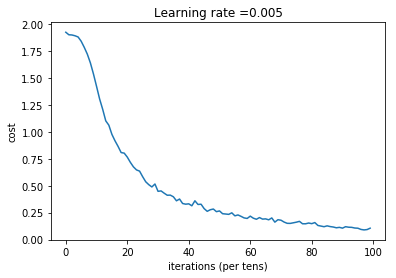

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.98333335
Test Accuracy: 0.875


In [37]:
_, _, parameters = model(train_images, train_labels, test_images, test_labels)

### predict using test image

Text(0.5,0,'5')

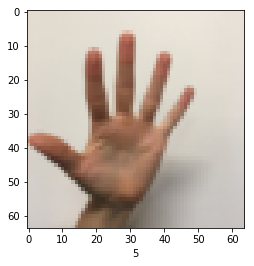

In [74]:
i = 3
plt.imshow(X_train_orig[i])
plt.xlabel(np.squeeze(Y_train_orig[:, i]))

In [85]:
pred_logits = forward_propagation(tf.cast(train_images[i][np.newaxis,:], 'float32'), parameters)
pred = tf.nn.softmax(pred_logits)
init = tf.global_variables_initializer()
     
with tf.Session() as sess:
    sess.run(init)
    pred = sess.run(pred)

print("Model predicted {0}".format(np.argmax(pred)))

Model predicted 5
